In [1]:
import time
import warnings
warnings.filterwarnings('ignore')

# For loading the dataframe
import pickle

# For loading data and data manipulation
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# For cleaning the text
from nltk.corpus import stopwords
from nltk import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

# For converting them into vectors
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# To find the similarity distance between movies
from sklearn.metrics.pairwise import cosine_similarity

# For model building libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Loading the datasets

In [2]:
df_predict = pickle.load(open("eda_data/predict.pkl", "rb"))
df_predict.head()

,Preferences,Category
0,I’m more of a tea person 🍵$$$I prefer herbal/d...,decaf
1,I’m more of a tea person 🍵$$$I prefer herbal/d...,sweet
2,"I don’t drink coffee or tea 🤭$$$ Chocolates, C...",hard liquor accessory liquoraccessory
3,"I don’t drink coffee or tea 🤭$$$ Chocolates, C...",sweet
4,I'm a coffee person ☕️$$$I like coffee but I d...,wine accessory liquoraccessory


# Clean the preference

In [3]:
# Creating object of tokenizer and lemmatizer
tokenizer = RegexpTokenizer(r"\w+")
lemmatizer = WordNetLemmatizer()

In [4]:
# Function to clean the Preference column
def clean(row):
    # convert into lower character
    row = row.lower()
    # split string into words
    words = tokenizer.tokenize(row)
    # remove stop words and apply lemmatization
    words = [lemmatizer.lemmatize(word.strip()) for word in words if word not in stopwords.words('english')]
    # convert word into string again and return
    return ' '.join(words)

In [5]:
%%time
# Applying clean preference function to transform the text
df_predict['Preference_Clean'] = df_predict['Preferences'].apply(clean)

CPU times: user 5.29 s, sys: 859 ms, total: 6.15 s
Wall time: 6.15 s


In [6]:
df_predict.head()

,Preferences,Category,Preference_Clean
0,I’m more of a tea person 🍵$$$I prefer herbal/d...,decaf,tea person prefer herbal de caffeinated tea ch...
1,I’m more of a tea person 🍵$$$I prefer herbal/d...,sweet,tea person prefer herbal de caffeinated tea ch...
2,"I don’t drink coffee or tea 🤭$$$ Chocolates, C...",hard liquor accessory liquoraccessory,drink coffee tea chocolate candy baked treat s...
3,"I don’t drink coffee or tea 🤭$$$ Chocolates, C...",sweet,drink coffee tea chocolate candy baked treat s...
4,I'm a coffee person ☕️$$$I like coffee but I d...,wine accessory liquoraccessory,coffee person like coffee like brew chocolate ...


# Split the data into train and test

In [7]:
X = df_predict['Preference_Clean']
y = df_predict['Category']

X.shape, y.shape

((2014,), (2014,))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1611,), (403,), (1611,), (403,))

# Converting feature into vectors

In [9]:
tfidf_predict = TfidfVectorizer(max_features=3000, stop_words='english')

In [10]:
X_train_vec = tfidf_predict.fit_transform(X_train).toarray()
X_test_vec = tfidf_predict.transform(X_test).toarray()

In [11]:
X_train_vec.shape

(1611, 560)

# Creating a model

<AxesSubplot:>

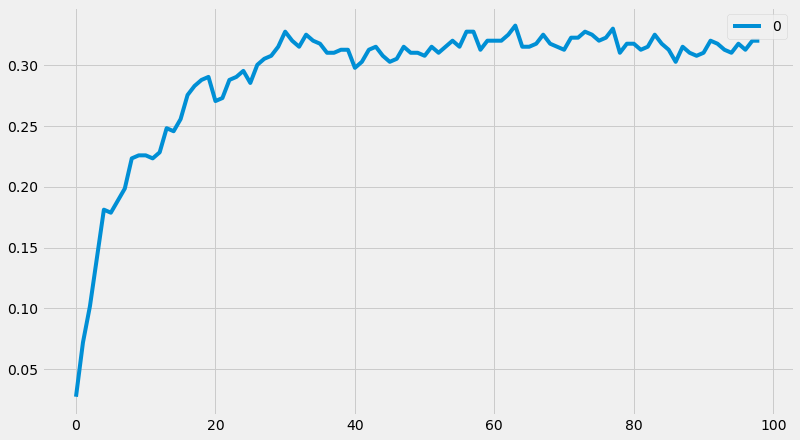

In [12]:
# Checking for the best value of n_neighbours in KNN
accuracy_knn = []
for i in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_vec, y_train)
    y_pred = knn.predict(X_test_vec)
    accuracy_knn.append(accuracy_score(y_test, y_pred))
    
pd.DataFrame(accuracy_knn).plot(figsize=(12,7))

### Increase the model performance:
* **Logic 1:** Initially, I am splitting the ProductTag with comma's and treat them as seperate category, so there were 39 ProductTag after splitting, and I am getting the best accuracy of **18 percent**
* **Logic 2:** After that I found out there were some ProductTag which were redundant with a difference of upper and lower character, so after converting all categories to lower character, and I am getting the best accuracy of around **20 percent**
* **Logic 3:** Then to improve further I remove the ProductTag that has less than 50 records, and I am getting the best accuracy of **23 percent**
* **Logic 4:** So, before I was spliting the ProductTag with comma's and treat them as a seperate category, but after removing that logic, I was directly using ProductTag with just string cleaning, and I am getting the best accuracy of around **40.9 percent**
* **Logic 5:** After Logic 4, I was only removing the ProductTag that has less than 30 records, and I am getting the best accuracy of **33.99 percent**

In [13]:
svc = SVC(kernel='sigmoid', gamma=1.0, probability=True)
knc = KNeighborsClassifier(n_neighbors=64)
bnb = BernoulliNB()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)

In [14]:
%%time
model_perf = []
classifiers = [svc, knc, bnb, mnb, dtc, lrc, rfc, abc, bc, etc, gbdt]
for classifier in classifiers:
    classifier.fit(X_train_vec, y_train)
    y_pred = classifier.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    model_perf.append({'Model': classifier, 'Accuracy': accuracy})

CPU times: user 17.1 s, sys: 1.41 s, total: 18.5 s
Wall time: 15.5 s


### Model performance

In [15]:
df_model_perf = pd.DataFrame(model_perf)
df_model_perf

,Model,Accuracy
0,"SVC(gamma=1.0, kernel='sigmoid', probability=T...",0.325062
1,KNeighborsClassifier(n_neighbors=64),0.332506
2,BernoulliNB(),0.258065
3,MultinomialNB(),0.215881
4,DecisionTreeClassifier(max_depth=5),0.285360
5,"LogisticRegression(penalty='l1', solver='libli...",0.339950
6,"(DecisionTreeClassifier(max_features='auto', r...",0.047146
7,"(DecisionTreeClassifier(max_depth=1, random_st...",0.183623
8,(DecisionTreeClassifier(random_state=114693939...,0.039702
9,"(ExtraTreeClassifier(random_state=1872583848),...",0.037221


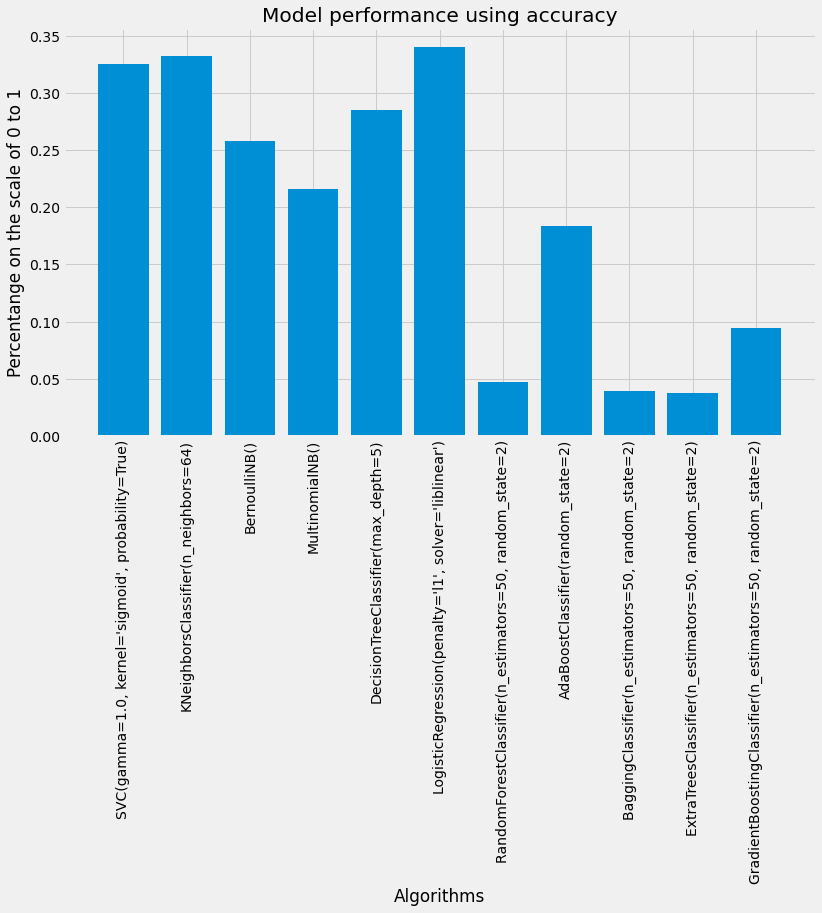

In [16]:
# Plot for the model performance
plt.figure(figsize=(12,7))
plt.bar(list(map(str, df_model_perf['Model'])), list(df_model_perf['Accuracy']))
plt.title('Model performance using accuracy')
plt.xlabel('Algorithms')
plt.xticks(rotation='vertical')
plt.ylabel('Percentange on the scale of 0 to 1')
plt.show()

# Picking the Support Vector Machine for prediction

In [17]:
# converting all the records into vectors
X_vec = tfidf_predict.fit_transform(X).toarray()
X_vec.shape

(2014, 569)

In [18]:
# training the SVC
svc = SVC(kernel='sigmoid', gamma=1.0, probability=True)
svc.fit(X_vec, y)

SVC(gamma=1.0, kernel='sigmoid', probability=True)

# Creating recommendation model

In [19]:
df_recommend = pickle.load(open("eda_data/recommendation.pkl", 'rb'))
df_recommend.head()

,ProductId,ProductName,ProductTag,Rating,Cost,Price,Tag
0,245,Guatemalan Signature Roast Ground Coffee,"coffee, ground",4.4427,13.78,25.99,guatemalan signature roast ground coffee coffe...
1,278,Los Gigantes Colombia (Coffee Beans),"coffee, artisanal",4.3185,10.75,20.00,los gigantes colombia coffee bean coffee artis...
2,351,Rowkin Bit Charge Stereo (Silver),music,4.0000,64.00,102.99,rowkin bit charge stereo silver music
3,424,Chocolate Fruit and Nut Dragee Sampler,sweet,4.4643,21.00,35.00,chocolate fruit nut dragee sampler sweet
4,700,Pro Lens Kit for Phone Camera,photography,4.3588,24.50,42.99,pro lens kit phone camera photography


### Converting tags column into vectors

In [20]:
tfidf_recommend = TfidfVectorizer(max_features=5000, stop_words='english')

In [21]:
recommend_vec = tfidf_recommend.fit_transform(df_recommend['Tag']).toarray()
recommend_vec

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
recommend_vec.shape

(341, 781)

### Calculate the cosine distance between the vectors, and the values of matrix represent the percentage of similarity between tags

In [23]:
similarity = cosine_similarity(recommend_vec)
similarity

array([[1.        , 0.25549427, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.25549427, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.87744968],
       [0.        , 0.        , 0.        , ..., 0.        , 0.87744968,
        1.        ]])

In [24]:
similarity.shape

(341, 341)

### Recommender function that will give the recommended movies closest to the given one

In [25]:
def recommender(product):
    product_index = df_recommend[df_recommend['ProductName'] == product].index[0]
    similarity_percentage = similarity[product_index]
    recommended_product = sorted(list(enumerate(similarity_percentage)), reverse=True, key=lambda x:x[1])[1:6]
    
    products = []
    for index in recommended_product:
        products.append(df_recommend.iloc[index[0]]['ProductName'])
        
    return products

In [26]:
recommender("Pecan Shortbread cookies")

['Vanilla Bean Shortbread Cookies',
 'The Luxe Collection Cocoa Shortbread',
 'Chocolate Cacao Nib Shortbread',
 'Original Speculoos Cookies- 4.8oz',
 'The Luxe Collection Almond Butter Cookies']

# Pipeline that recommends products on the basis of preference
* Logistic Regression and Support Vector Machine have the same accuracy
* So first predicting with the Logistic Regression
* And then try with the Support Vector Machine
* And getting better results with Support Vector Machine

### Gift boxes with 20 percent profit atleast
**NOTE: Margin should be atleast 20 percent** 

In [27]:
def margin_percentage(price, cost):
    total_amount_charged = price
    total_cost = cost
    shipping_fees = 9.5
    strip_fee = ((total_amount_charged * 2.9) / 100) + 0.3
    
    margin = total_amount_charged - total_cost - shipping_fees - strip_fee
    margin_percentage = ((margin * 100) / total_amount_charged)

    return margin_percentage

In [28]:
def product_group(product_price, order_price):
    # converting dictionary into 2D array
    product_list = [product_price[category] for category in product_price]
    
    # finding the max number of products in any sub array
    max_groups = 0
    for product in product_list:
        if max_groups < len(product):
            max_groups = len(product)
    
    # creating groups of products 
    groups = []
    for i in range(max_groups):
        temp_group = []
        for j in range(len(product_list)):
            if len(product_list[j]) > i:
                temp_group.append(product_list[j][i])
            else:
                temp_group.append(product_list[j][len(product_list[j])-1])
        groups.append(temp_group)
    
    # creating box of products maintaining 20 percent margin
    boxes = []
    for group in groups:
        ids = ''
        cost = 0.0
        price = 0.0
        margin_satisfy = False
        
        for product in group:
            ids += str(product[0]) + ','
            cost += product[1]
            price += product[2]
            if margin_percentage(price, cost) >= 20:
                margin_satisfy = True
                break

        if margin_satisfy:
            ids = ids[:len(ids) - 1]
            box = [ids, price]
            boxes.append(box)
    
    return sorted(boxes, key=lambda x: x[1], reverse=True)[:3]

In [29]:
def product_category(preds):
    # fecthing all the products which has category as product
    df_product = pd.DataFrame(columns=['ProductId', 'ProductName', 'ProductTag', 'Rating', 'Cost', 'Price'])
    product_dic = {}
    for pred in preds:
        # adding pred as key in dic
        product_dic[pred]= []
        
        # fetching products on the basis of category
        df_temp = df_recommend[df_recommend['ProductTag'].apply(lambda product_tag: pred in clean(product_tag))]
        # filtering products with more than 4 category
        df_temp = df_temp[df_temp['Rating'] > 4]
        # sorting products on the basis of price
        df_temp = df_temp.sort_values(by=['Price'], ascending=False)
        # top price product
        top_price_product = df_temp.iloc[0]['ProductName']
        
        # assinging top price product item into df_product dataframe
        df_product.loc[len(df_product.index)] = df_temp.iloc[0]
        # fetching product id, cost and price of the top price product
        dic_value = list(df_temp.iloc[0][['ProductId', 'Cost', 'Price']].values)
        # storing dic_value into the product_dic
        product_dic[pred].append(dic_value)
        
        # recommend products on the bsis of top price product
        product_recommendations = recommender(top_price_product)
        
        for product in product_recommendations:
            # fetching product with product name
            df_temp = df_recommend[df_recommend['ProductName'] == product]
            # filtering if product has more than 4 category
            df_temp = df_temp[df_temp['Rating'] > 4]
            
            # checking after filtering df_temp has any record or not
            if df_temp.shape[0] != 0:
                # assinging item into df_product dataframe
                df_product.loc[len(df_product.index)] = df_temp.iloc[0]
                # fetching product id, cost and price
                dic_value = list(df_temp.iloc[0][['ProductId', 'Cost', 'Price']].values)
                # storing dic_value into the product_dic
                product_dic[pred].append(dic_value)

    return product_dic

In [30]:
def gift_boxes(pref, order_price):
    # creating a dataframe
    df = pd.DataFrame({"Preference": [pref]})
    
    # cleaning the preference
    df['Preference_Clean'] = df['Preference'].apply(clean)
    
    # transform the preference into vectors
    df_vec = tfidf_predict.transform(df['Preference_Clean']).toarray()
    
    # predict the category
    pred = svc.predict(df_vec)[0]
    
    # predict probability
    pred_prob = svc.predict_proba(df_vec)[0]
    
    # dictionary of category with its probability
    category_prob = {}
    for i in range(len(pred_prob)):
        category_prob[svc.classes_[i]] = pred_prob[i]
    
    # sort the dictionary to get the max two
    category_prob_sort = dict(sorted(category_prob.items(), key=lambda item: item[1], reverse=True))
    
    # taking the categories which has a predicted percentage of more than or equal to 10 percent
    preds = []
    for category in category_prob_sort.keys():
        if category_prob_sort[category] >= 0.1:
            preds.append(category)
        if len(preds) > 3:
            break
    
    # fetching products on the basis of category
    products_price = product_category(preds)
    
    return product_group(products_price, order_price)

# Check with test data

In [31]:
df_test_sample = pd.read_csv("data/test_input.csv")
df_test_sample.head()

,Unnamed: 0,OrderID,OrderPrice,Preferences
0,1001,171888537,40,I'm a coffee person ☕️$$$I love to make pour o...
1,1002,171888536,40,I'm a coffee person ☕️$$$I love to make pour o...
2,1003,171888535,40,"I don’t drink coffee or tea 🤭$$$ Chocolates, C..."
3,1004,171888533,30,I'm a coffee person ☕️$$$I love to make pour o...
4,1005,171888532,50,I’m more of a tea person 🍵$$$Any specialty tea...


In [32]:
df_test_sample = df_test_sample[['OrderPrice', 'Preferences']]
df_test_sample.head()

,OrderPrice,Preferences
0,40,I'm a coffee person ☕️$$$I love to make pour o...
1,40,I'm a coffee person ☕️$$$I love to make pour o...
2,40,"I don’t drink coffee or tea 🤭$$$ Chocolates, C..."
3,30,I'm a coffee person ☕️$$$I love to make pour o...
4,50,I’m more of a tea person 🍵$$$Any specialty tea...


In [33]:
for i in range(0, 10):
    preference = df_test_sample['Preferences'][i]
    order_price = df_test_sample['OrderPrice'][i]

    print("Preference:", preference)
    print("-\nOrder Price:", order_price)
    print("-\nRecommended Gift Boxes:--------------------------")
    gift_box = gift_boxes(preference, order_price)
    for j in range(len(gift_box)):
        print(f"Gift Box: {j + 1} => Product Id: ({gift_box[j][0]}), Total Amount Charged: {gift_box[j][1]}$") 
    print("\n================================================\n")

Preference: I'm a coffee person ☕️$$$I love to make pour over/specialty coffees from coffee beans 🙋‍♀️☕️$$$ Savories and non-sweet snacks 🥓 🥕🥨 $$$  Chocolates, Candies and baked treats 🍫 🍪 🍩 $$$  I do NOT have any allergies or dietary restrictions 👍 $$$ $$$Send 👍$$$I like everything 👍$$$ 📱🏡 Smart home gadgets are so cool. I love them. $$$  $$$ $$$Have kid/s Girl-2yrs boy-3mo years old$$$Send 👍$$$ I love being outdoors 🚶‍♀️ $$$ $$$Send 👍
-
Order Price: 40
-
Recommended Gift Boxes:--------------------------
Gift Box: 1 => Product Id: (2132,424), Total Amount Charged: 57.0$
Gift Box: 2 => Product Id: (2426,2999), Total Amount Charged: 52.0$
Gift Box: 3 => Product Id: (1220,2241), Total Amount Charged: 33.7$


Preference: I'm a coffee person ☕️$$$I love to make pour over/specialty coffees from coffee beans 🙋‍♀️☕️$$$ Savories and non-sweet snacks 🥓 🥕🥨 $$$  Chocolates, Candies and baked treats 🍫 🍪 🍩 $$$ $$$Send 👍$$$Hard liquor (for example -- Whiskey, Bourbon, Rum, Tequila) 🥃$$$ 📱🏡 Smart hom